In [ ]:
# NB! Heavily inspired by: https://www.analyticsvidhya.com/blog/2021/05/bitcoin-price-prediction-using-recurrent-neural-networks-and-lstm/

Necessary imports:

In [285]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Preprocessing
We start by reading the downloaded time series with Pandas. The data has invalid price values, indicated by ".", so we have to remove these and impose the prices to be numeric again.

In [286]:
df = pd.read_csv('../Tidsrekker/CBLTCUSD.csv', date_parser = True)
# Sort out invalid price
df['CBLTCUSD'] = df['CBLTCUSD'][~(df['CBLTCUSD'] == '.' )]
df['CBLTCUSD'] = pd.to_numeric(df['CBLTCUSD'])

df.tail()

,DATE,CBLTCUSD
1822,2021-09-23,164.05
1823,2021-09-24,152.30
1824,2021-09-25,151.04
1825,2021-09-26,150.55
1826,2021-09-27,145.34


Here, we split the data in a training and testing DataFrame. We also drop the actual dates from the training data.

In [339]:
n = len(df)
train_df = df[0:int(n*0.9)] # df[0:int(n*0.7)]
test_df = df[int(n*0.9):] # df[int(n*0.9):]

df_train = train_df.drop('DATE', axis=1)
test_df.tail()

,DATE,CBLTCUSD
1822,2021-09-23,164.05
1823,2021-09-24,152.30
1824,2021-09-25,151.04
1825,2021-09-26,150.55
1826,2021-09-27,145.34


The data is normalized with Keras' MinMaxScaler so it's ready to be passed into the network.

In [288]:
scaler = MinMaxScaler()
df_train = scaler.fit_transform(df_train)
df_train

array([[0.00098342],
       [0.00092723],
       [0.00101152],
       ...,
       [0.50778309],
       [0.50823265],
       [0.50834504]])

Pass inputs parameters properly to be inserted to model

In [289]:
X_train = [] 
Y_train = []
for i in range(60, df_train.shape[0]):
     X_train.append(df_train[i-60:i])
     Y_train.append(df_train[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_train.shape

(1584, 60, 1)

# Building the model
Here we state the LSTM model. It has 4 layers with one droput and one Dense layer

In [319]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
# Initialize RNN
model = Sequential() 
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
# model.add(Dropout(0.3))
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
# model.add(Dropout(0.4))
model.add(LSTM(units = 120, activation = 'relu'))
# model.add(Dropout(0.5))
model.add(Dense(units =1))
model.summary()


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_98 (LSTM)               (None, 60, 50)            10400     
_________________________________________________________________
dropout_96 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_99 (LSTM)               (None, 60, 60)            26640     
_________________________________________________________________
lstm_100 (LSTM)              (None, 60, 80)            45120     
_________________________________________________________________
lstm_101 (LSTM)              (None, 120)               96480     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 121       
Total params: 178,761
Trainable params: 178,761
Non-trainable params: 0
_______________________________________________

# Fitting the model

In [329]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
NUM_EPOCH = 20
history= model.fit(X_train, Y_train, epochs = NUM_EPOCH, batch_size = 128, validation_split=0.20)

Epoch 1/20
10/10 [==============================] - 8s 418ms/step - loss: 0.0030 - val_loss: nan
Epoch 2/20
10/10 [==============================] - 3s 350ms/step - loss: 0.0024 - val_loss: nan
Epoch 3/20
10/10 [==============================] - 4s 357ms/step - loss: 0.0023 - val_loss: nan
Epoch 4/20
10/10 [==============================] - 4s 393ms/step - loss: 0.0021 - val_loss: nan
Epoch 5/20
10/10 [==============================] - 4s 419ms/step - loss: 0.0018 - val_loss: nan
Epoch 6/20
10/10 [==============================] - 4s 381ms/step - loss: 0.0018 - val_loss: nan
Epoch 7/20
10/10 [==============================] - 4s 390ms/step - loss: 0.0018 - val_loss: nan
Epoch 8/20
10/10 [==============================] - 4s 403ms/step - loss: 0.0016 - val_loss: nan
Epoch 9/20
10/10 [==============================] - 4s 381ms/step - loss: 0.0017 - val_loss: nan
Epoch 10/20
10/10 [==============================] - 4s 374ms/step - loss: 0.0017 - val_loss: nan
Epoch 11/20
10/10 [==========

We find the loss for each epoch:

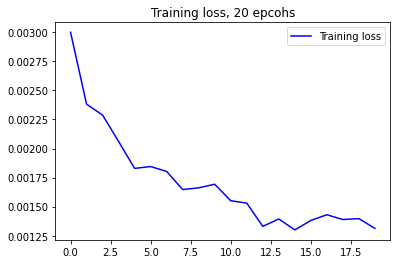

In [330]:
loss = history.history['loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training loss, " + str(NUM_EPOCH)+ " epcohs")
plt.legend()
plt.savefig("Train_loss_" + str(NUM_EPOCH) + "_epochs.pdf")
plt.show()

# Testing the fit of the model

In [331]:
part_60_days = train_df.tail(60)
df2= part_60_days.append(test_df, ignore_index = True)
df2 = df2.drop(['DATE'], axis = 1)
df2.head()

,CBLTCUSD
0,133.74
1,135.28
2,133.18
3,129.39
4,132.05


In [332]:
inputs = scaler.transform(df2)
# inputs

In [333]:
X_test = []
Y_test = []
for i in range (60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    Y_test.append(inputs[i, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test.shape, Y_test.shape

((183, 60, 1), (183,))

In [334]:
Y_pred = model.predict(X_test)
# Y_pred, Y_test

In [335]:
scaler.scale_

array([0.00280978])

In [336]:
scale = 1/scaler.scale_
Y_test = Y_test*scale
Y_pred = Y_pred*scale

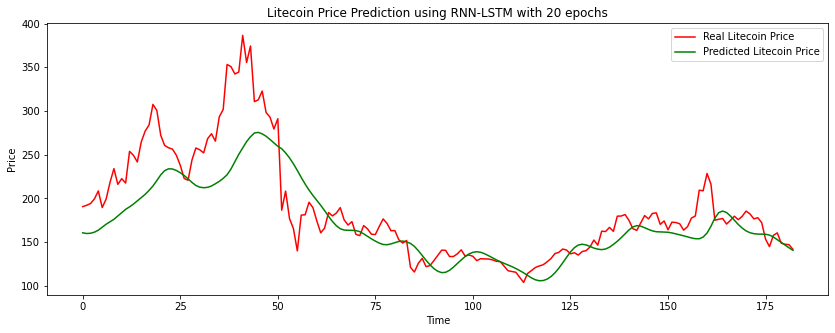

In [337]:
plt.figure(figsize=(14,5))
plt.plot(Y_test, color = 'red', label = 'Real Litecoin Price')
plt.plot(Y_pred, color = 'green', label = 'Predicted Litecoin Price')
plt.title('Litecoin Price Prediction using RNN-LSTM with ' + str(NUM_EPOCH) + ' epochs')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.savefig("LSTM-pred-" + str(NUM_EPOCH) + "-epochs.pdf")
plt.show()